# Customer Churn

# Table of Contents

- [Problem Statement](#Problem-Statement)
- [Imports](#Imports)
- [Data Loading](#Data-Loading)
- [Data Merging](#Data-Merging)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-\(EDA\))
    - [Data Overview](#Data-Overview)
    - [Null/NaN Values](#Null/NaN-Values)
    - [Data Visualization](#Data-Visualization)
- [Preliminary Baseline Model](#Preliminary-Baseline-Model)
    - [Selecting 'Satisfaction Score' as a Single Feature for Baseline Model](#Selecting-'Satisfaction-Score'-as-a-Single-Feature-for-Baseline-Model)
    - [Baseline Model Evaluation](#Baseline-Model-Evaluation)
        - [Classification Report](#Classification-Report)
        - [Confusion Matrix](#Confusion-Matrix)
        - [Accuracy Score](#Accuracy-Score)
- [Data Preprocessing](#Data-Preprocessing)
    - [Categorical to Numerical Conversion](#Categorical-to-Numerical-Conversion)
    - [Visualization of Converted Features](#Visualization-of-Converted-Features)
        - [Cluster Map](#Cluster-Map)
        - [t-SNE Visualization](#t-SNE-Visualization)
- [Refined Model Development](#Refined-Model-Development)
    - [Feature Engineering and Selection](#Feature-Engineering-and-Selection)
        - [Potential Predictive Features Identification](#Potential-Predictive-Features-Identification)
        - [Feature Importance Analysis](#Feature-Importance-Analysis)
        - [Feature Selection](#Feature-Selection)
        - [Dimensionality Reduction](#Dimensionality-Reduction)
    - [Handling Class Imbalance](#Handling-Class-Imbalance)
    - [Model Comparisons](#Model-Comparisons)
        - [Logistic Regression Model](#Logistic-Regression-Model)
            - [Analysis of Logistic Regression Model](#Analysis-of-Logistic-Regression-Model)
        - [Random Forest Model](#Random-Forest-Model)
            - [Analysis of Random Forest Model](#Analysis-of-Random-Forest-Model)
            - [Feature Importance in RandomForest Model](#Feature-Importance-in-RandomForest-Model)
    - [Model Tuning](#Model-Tuning)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion](#Conclusion)

# Problem Statement

Customer churn is a significant concern for any business, especially in the telecommunications industry. Churn rate can significantly impact a company's revenue and market share. In this project, we are working with a dataset from a fictional telecommunications company - Telco. The data represents the information about 7043 customers in California for Q3, including those who left, stayed, or signed up for the service.

The aim of this project is to understand and predict customer churn, i.e., identify the factors that lead to customer churn and use this understanding to predict whether a customer is likely to churn in the future. These insights will help the company in developing effective customer retention strategies and enhance customer satisfaction.

To conduct this analysis, we are provided with multiple data points for each customer, including but not limited to demographics, location, services used, customer satisfaction score, churn score, and Customer Lifetime Value (CLTV).

The Telco data module comprises five main categories:

1. Demographics - Customer's unique ID, gender, age, marital status, dependents, etc.
2. Location - Details about the customer's primary residence.
3. Population - Estimated population of the customer's zip code area.
4. Services - Details about the services a customer is using and their billing information.
5. Status - This includes customer satisfaction score, churn label, churn value, churn score, CLTV, and reason for churn if applicable.

# Imports

In [64]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import RandomizedSearchCV

# Data Loading

In [2]:
os.chdir('..')

In [3]:
cust_churn = pd.read_excel('data/Telco_customer_churn.xlsx')
demo = pd.read_excel('data/Telco_customer_churn_demographics.xlsx')
location = pd.read_excel('data/Telco_customer_churn_location.xlsx')
population = pd.read_excel('data/Telco_customer_churn_population.xlsx')
services = pd.read_excel('data/Telco_customer_churn_services.xlsx')
status = pd.read_excel('data/Telco_customer_churn_status.xlsx')
churn = pd.read_excel('data/Telco_customer_churn.xlsx')

# Data Merging

In [4]:
# Combine on Customer ID
churn_all = demo.merge(location, on='Customer ID')
churn_all = churn_all.merge(services, on='Customer ID')

# Include the 'Churn' column and any other relevant columns from the 'status' dataframe.
churn_all = churn_all.merge(status, on='Customer ID')

C:\Users\sergi\AppData\Local\Temp\ipykernel_18084\754748716.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Count_x'} in the result is deprecated and will raise a MergeError in a future version.
  churn_all = churn_all.merge(status, on='Customer ID')


# Data Cleaning

In [5]:
# Drop duplicated counts
churn_all.drop(['Count_x', 'Count_y'], axis=1, inplace=True)

# Drop all uniform columns
churn_all.drop(['Country', 'State', 'Quarter_x', 'Quarter_y'], axis=1, inplace=True)

# Drop columns that are redundant or unable to be converted to numerics
churn_all.drop(['Location ID', 'Service ID', 'Customer ID', 'Lat Long', 'City', 'Status ID'], axis=1, inplace=True)

# Exploratory Data Analysis (EDA)

## Data Overview

In [6]:
# Print the shape of the dataframe
print('Number of rows: ', churn_all.shape[0])
print('Number of columns: ', churn_all.shape[1])

Number of rows:  7043
Number of columns:  45


In [7]:
# Look at first 5 rows
churn_all.head()

,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Zip Code,Latitude,Longitude,...,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason
0,Male,78,No,Yes,No,No,0,90022,34.023810,-118.156582,...,0.00,59.65,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data
1,Female,74,No,Yes,Yes,Yes,1,90063,34.044271,-118.185237,...,390.80,1024.10,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer
2,Male,71,No,Yes,No,Yes,3,90065,34.108833,-118.229715,...,203.94,1910.88,2,Churned,Yes,1,81,3179,Competitor,Competitor made better offer
3,Female,78,No,Yes,Yes,Yes,1,90303,33.936291,-118.332639,...,494.00,2995.07,2,Churned,Yes,1,88,5337,Dissatisfaction,Limited range of services
4,Female,80,No,Yes,Yes,Yes,1,90602,33.972119,-118.020188,...,234.21,3102.36,2,Churned,Yes,1,67,2793,Price,Extra data charges


In [8]:
# Summary of the dataframe
churn_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   object 
 1   Age                                7043 non-null   int64  
 2   Under 30                           7043 non-null   object 
 3   Senior Citizen                     7043 non-null   object 
 4   Married                            7043 non-null   object 
 5   Dependents                         7043 non-null   object 
 6   Number of Dependents               7043 non-null   int64  
 7   Zip Code                           7043 non-null   int64  
 8   Latitude                           7043 non-null   float64
 9   Longitude                          7043 non-null   float64
 10  Referred a Friend                  7043 non-null   object 
 11  Number of Referrals                7043 non-null   int64

In [9]:
# Summary statistics for numerical columns
churn_all.describe()

,Age,Number of Dependents,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Churn Value,Churn Score,CLTV
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,93486.071134,36.197455,-119.756684,1.951867,32.386767,22.958954,20.515405,64.761692,2280.381264,1.962182,6.860713,749.099262,3034.379056,3.244924,0.265370,58.505040,4400.295755
std,16.750352,0.962802,1856.768045,2.468929,2.154425,3.001199,24.542061,15.448113,20.418940,30.090047,2266.220462,7.902614,25.104978,846.660055,2865.204542,1.201657,0.441561,21.170031,1183.057152
min,19.000000,0.000000,90001.000000,32.555828,-124.301372,0.000000,1.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,21.360000,1.000000,0.000000,5.000000,2003.000000
25%,32.000000,0.000000,92101.000000,33.990646,-121.788090,0.000000,9.000000,9.210000,3.000000,35.500000,400.150000,0.000000,0.000000,70.545000,605.610000,3.000000,0.000000,40.000000,3469.000000
50%,46.000000,0.000000,93518.000000,36.205465,-119.595293,0.000000,29.000000,22.890000,17.000000,70.350000,1394.550000,0.000000,0.000000,401.440000,2108.640000,3.000000,0.000000,61.000000,4527.000000
75%,60.000000,0.000000,95329.000000,38.161321,-117.969795,3.000000,55.000000,36.395000,27.000000,89.850000,3786.600000,0.000000,0.000000,1191.100000,4801.145000,4.000000,1.000000,75.500000,5380.500000
max,80.000000,9.000000,96150.000000,41.962127,-114.192901,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000,5.000000,1.000000,96.000000,6500.000000


## Null/NaN Values

In [10]:
# Check for missing values
missing_values = churn_all.isnull().sum()
print('Missing values per column:\n', missing_values[missing_values > 0])

Missing values per column:
 Churn Category    5174
Churn Reason      5174
dtype: int64


Looking into Churn Category & Churn Reason.

***Assumption***: 5174 cases of no churn (custom has not left), therefore it is NaN.

In [11]:
# Subset the data where 'Churn Category' and 'Churn Reason' are null
missing_churn_info = churn_all[churn_all['Churn Category'].isnull() & churn_all['Churn Reason'].isnull()]

# Check the 'Churn Label' column of this subset
churn_labels_in_missing = missing_churn_info['Churn Label'].value_counts()

print(churn_labels_in_missing)

No    5174
Name: Churn Label, dtype: int64


***Assumption is confirmed.***

All instances of Null/NaN (being in Churn Category and Churn Reason columns) are where the Churn Label is 'No', therefore, the customer has not churned. 

To fix this, we will impute another category into Churn Category and Churn Reason, for instances of NaN's,

***Churn Category*** will be called ***'Retention'***

***Churn Reason*** will be called ***'Customer Retained'***

In [12]:
churn_all['Churn Category'].fillna('Retention', inplace=True)
churn_all['Churn Reason'].fillna('Customer Retained', inplace=True)

## Data Visualization

<Axes: xlabel='Churn Label', ylabel='Count'>

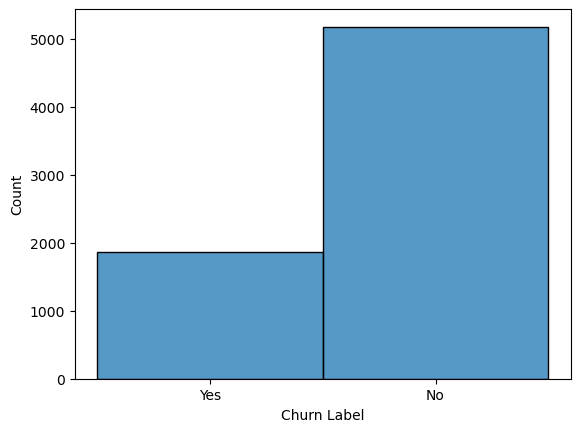

In [13]:
# Histogram of the target variable
sns.histplot(churn_all['Churn Label'])

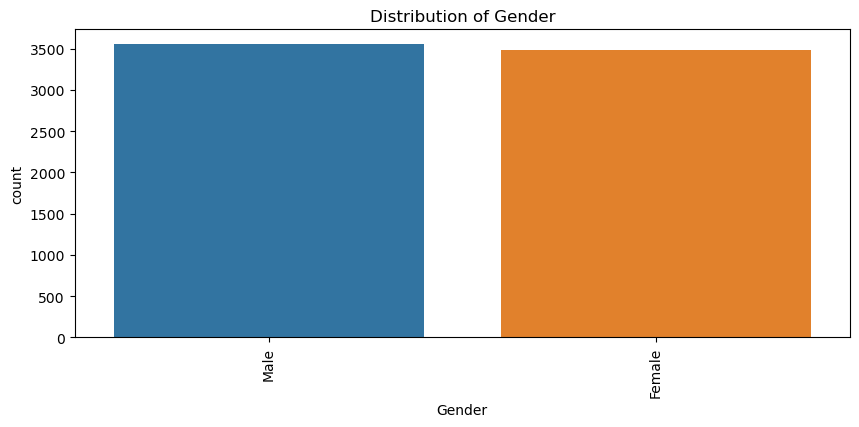

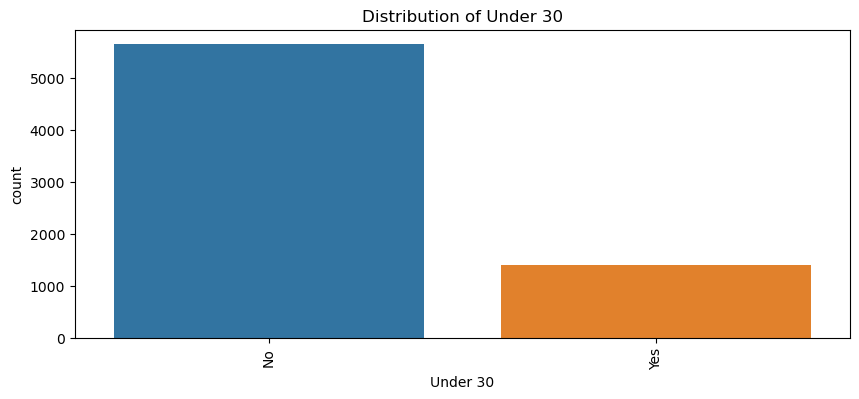

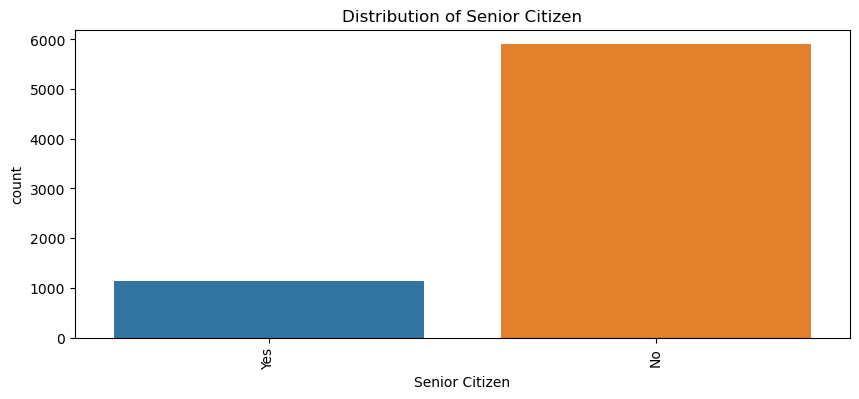

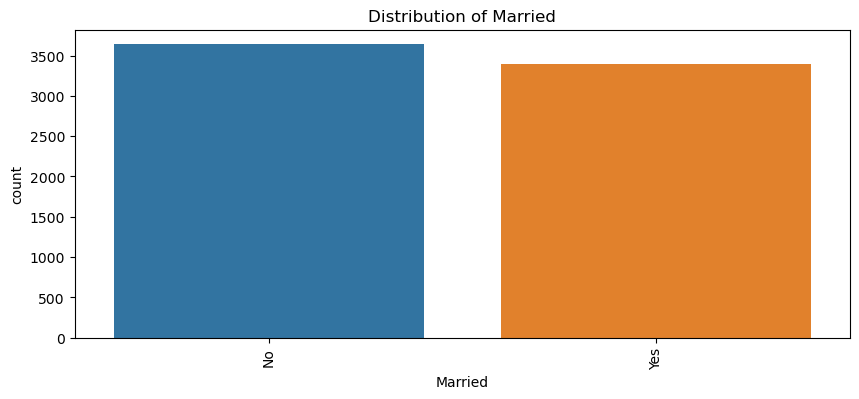

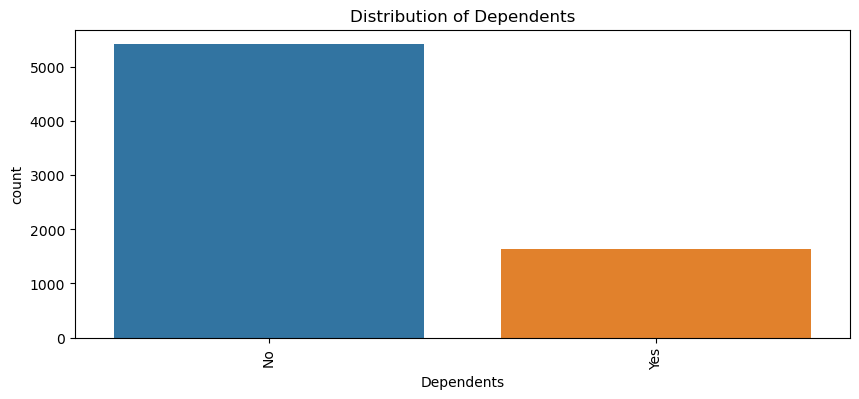

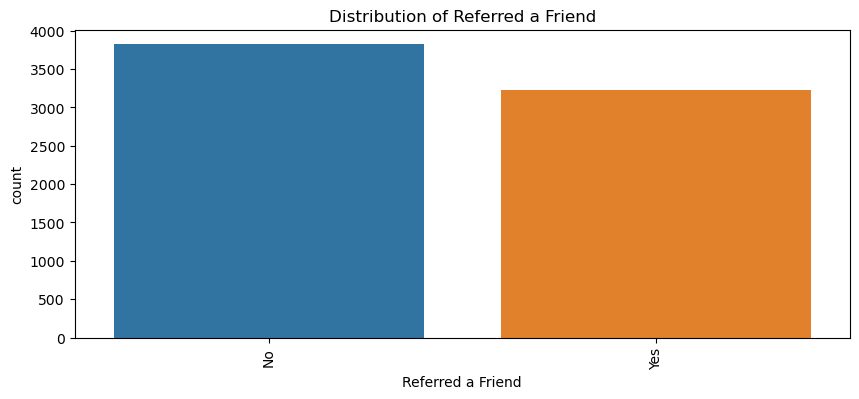

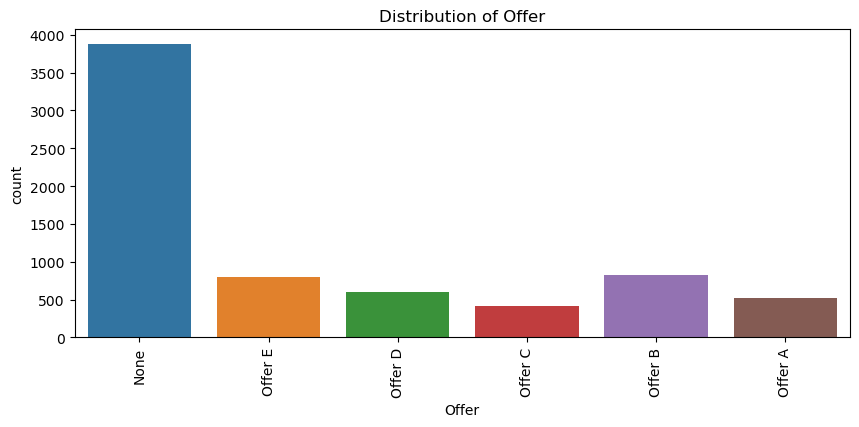

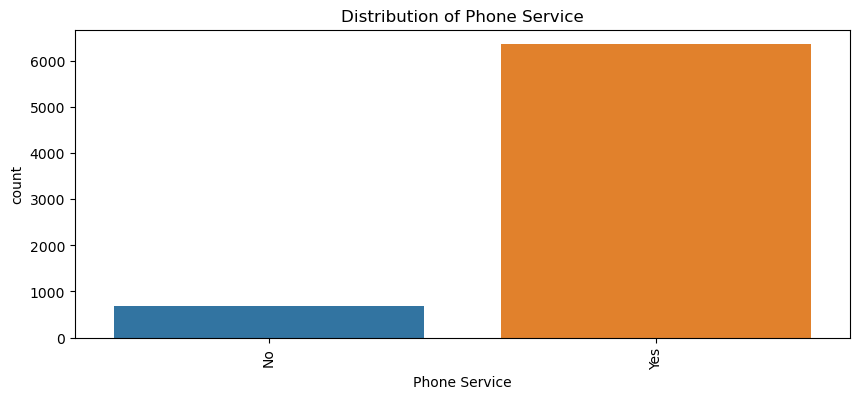

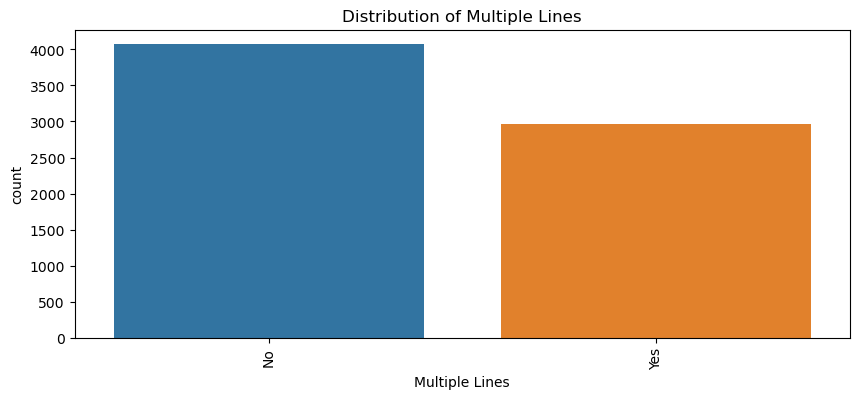

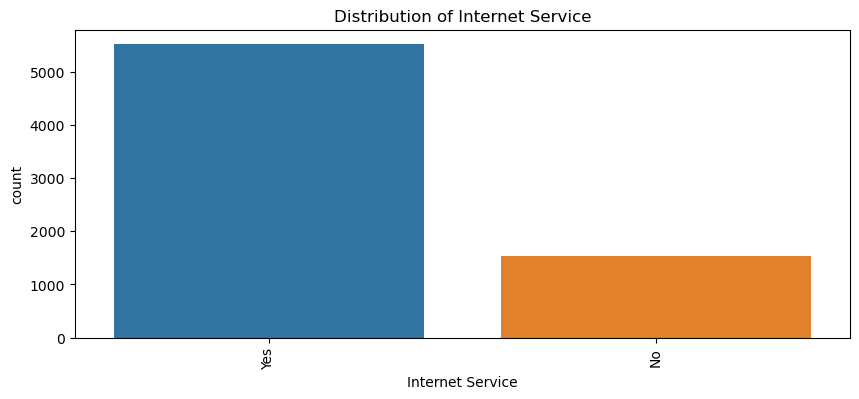

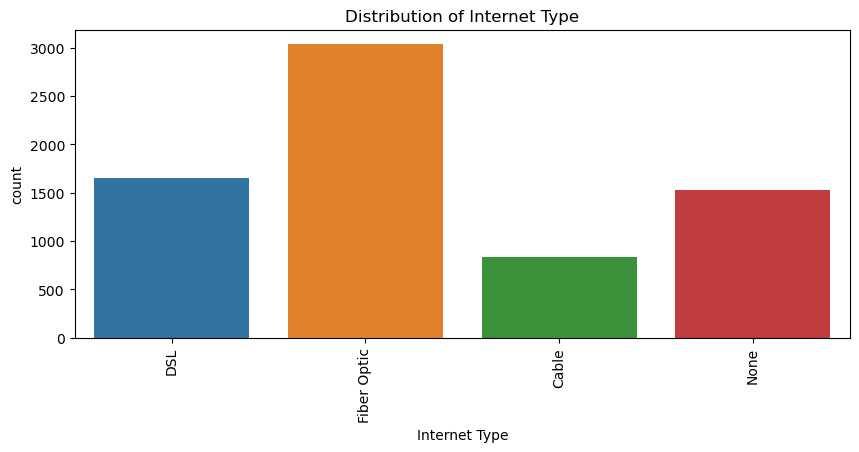

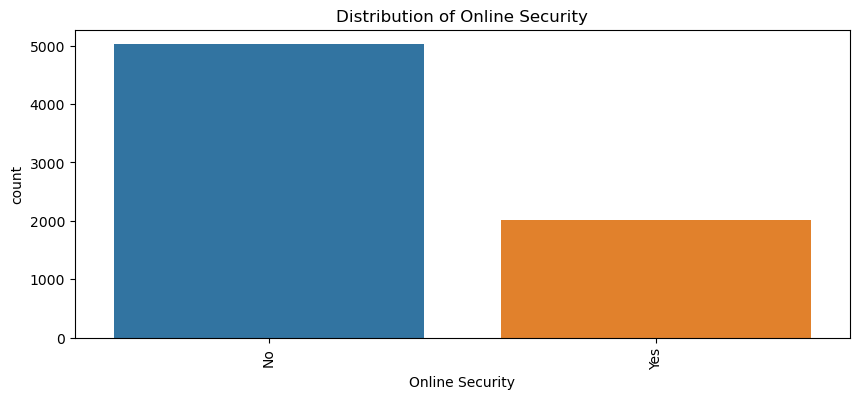

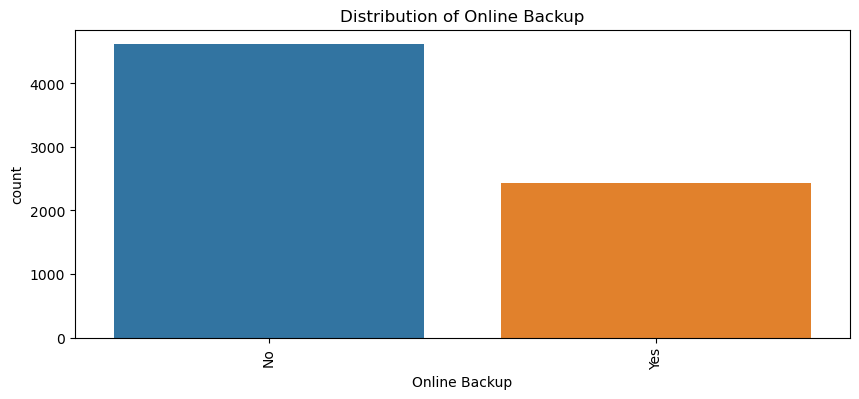

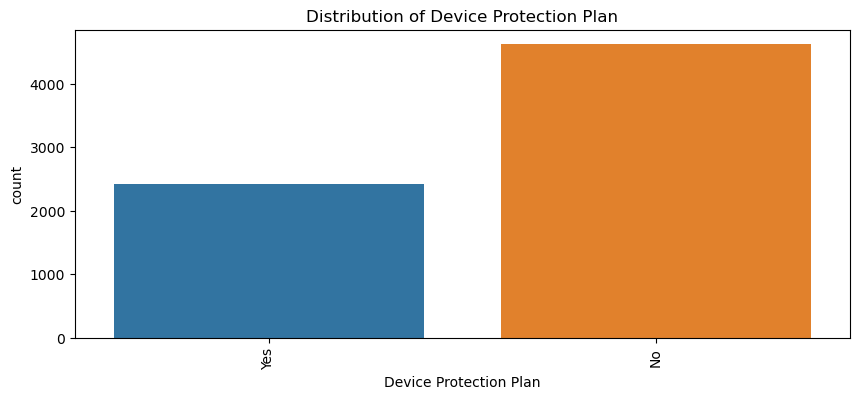

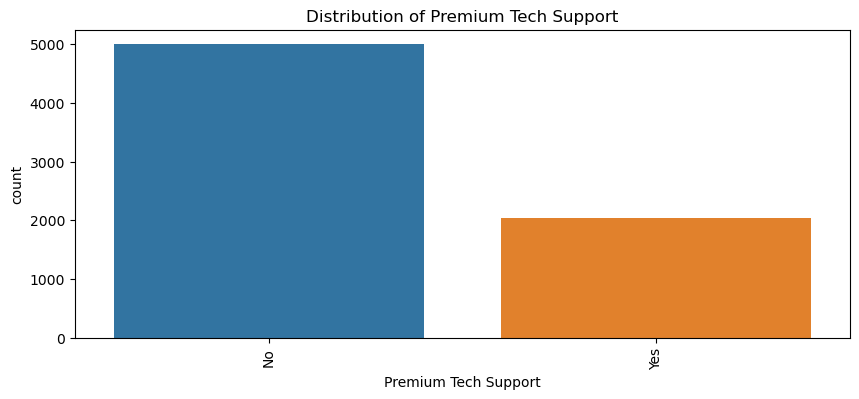

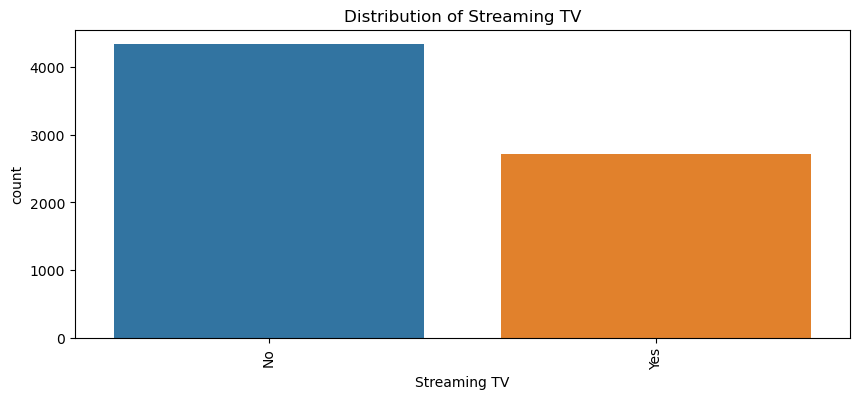

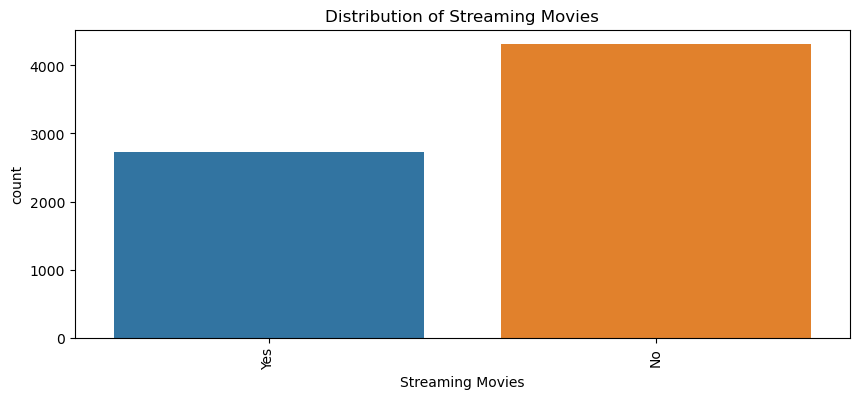

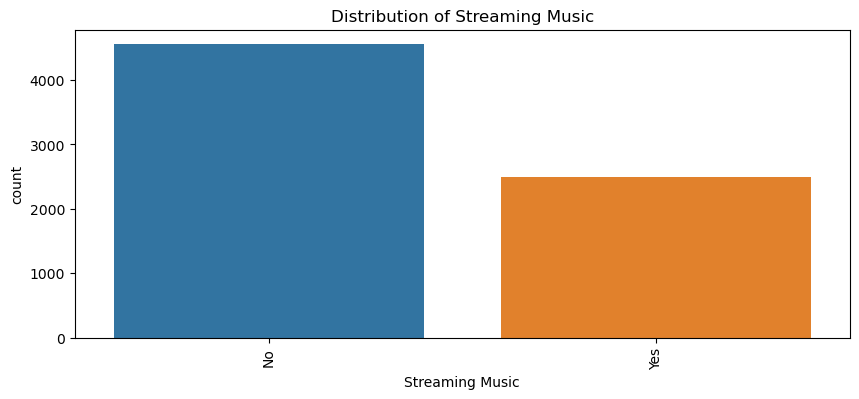

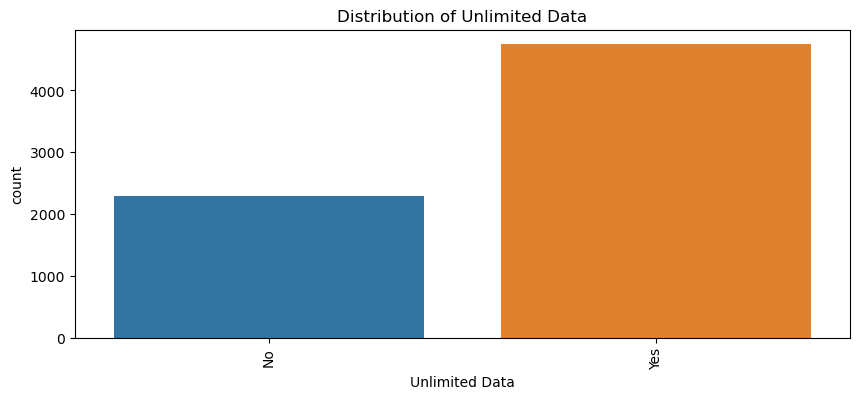

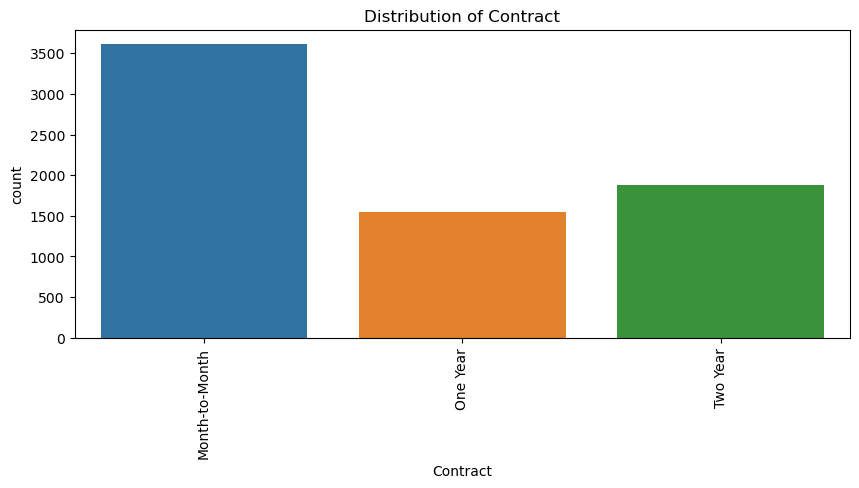

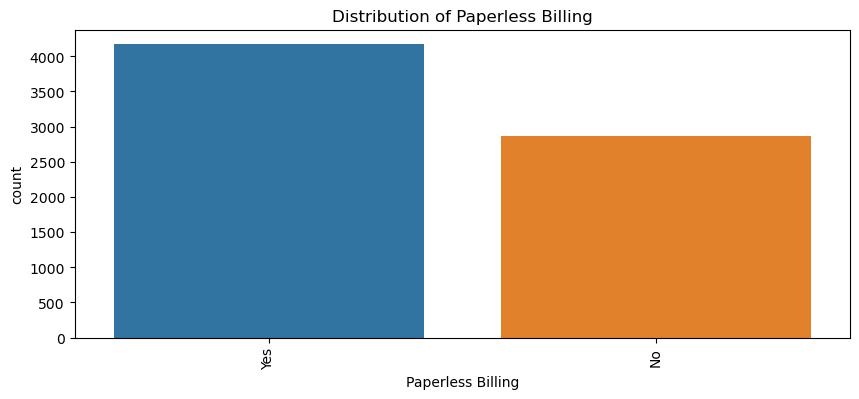

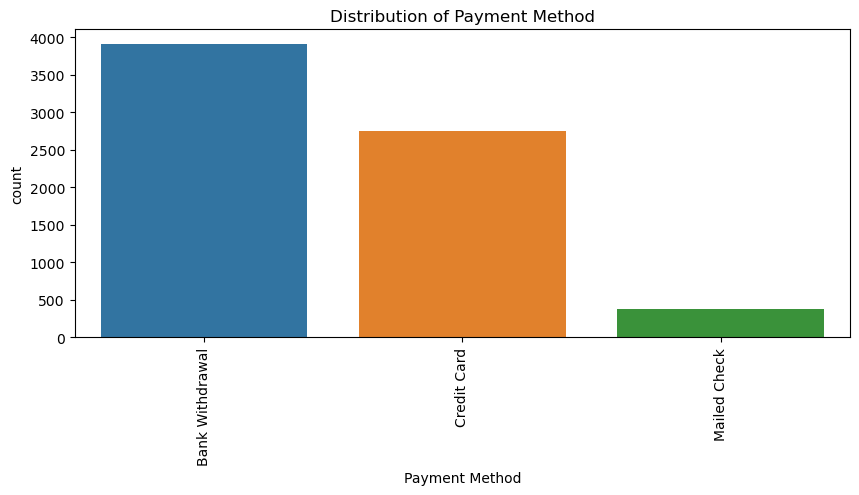

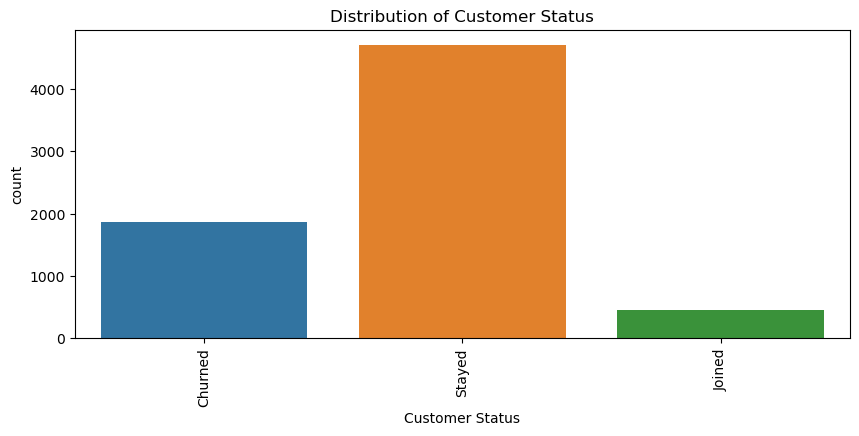

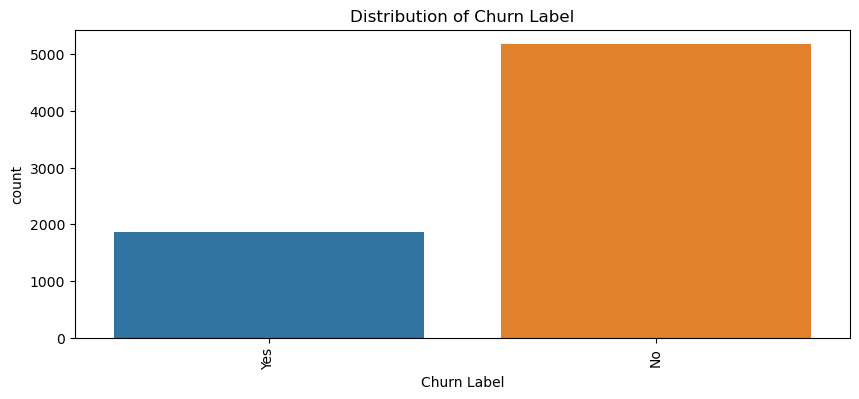

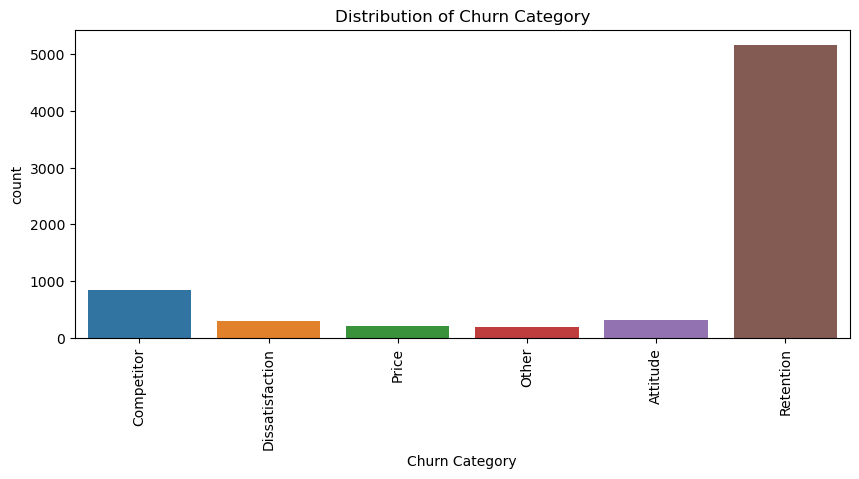

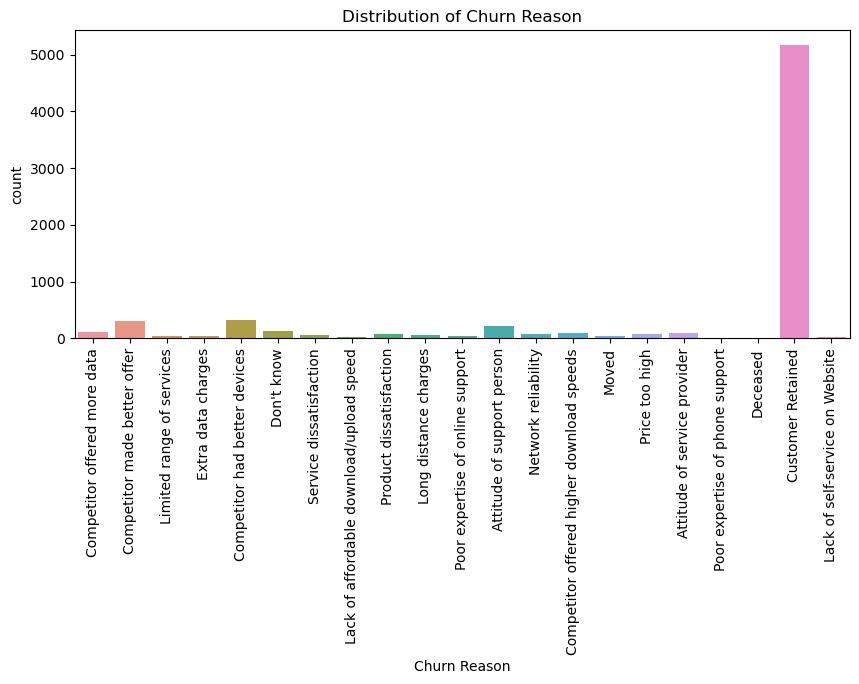

In [14]:
# Bar plots for categorical variables
categorical_cols = churn_all.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(10,4))
    sns.countplot(x=col, data=churn_all)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=90)
    plt.show()

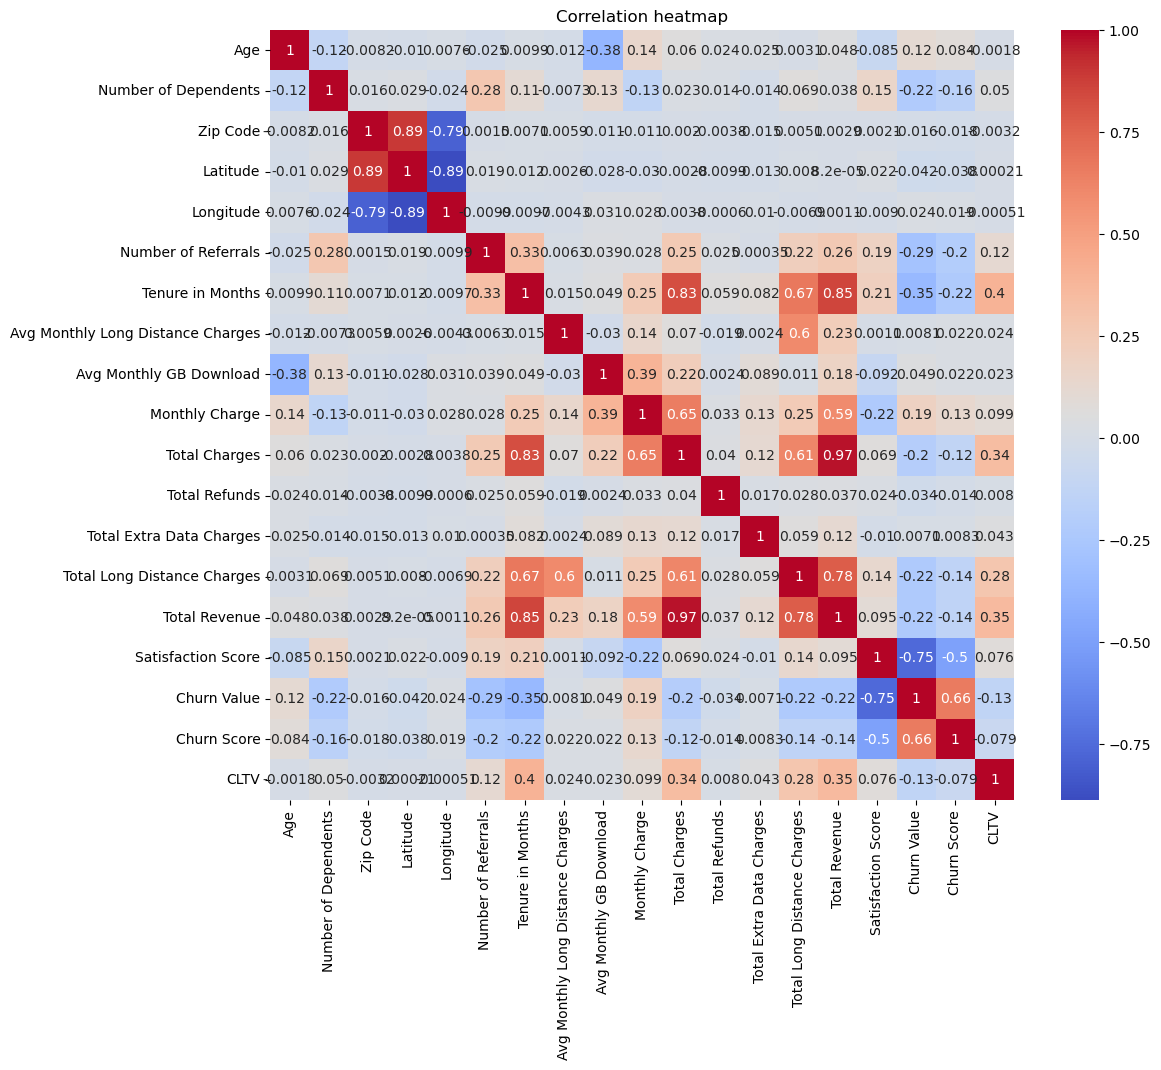

In [15]:
# Correlation heatmap for numerical variables
numerical_cols = churn_all.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12,10))
sns.heatmap(churn_all[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation heatmap')
plt.show()

# Preliminary Baseline Model

## Selecting 'Satisfaction Score' as a Single Feature for Baseline Model

In this section, we will build a preliminary baseline model using the feature that's most highly correlated with our target variable, `Churn Value`. The feature we'll use is `Satisfaction Score`. 

By starting with a simple model, we can establish a baseline level of performance to compare with more complex models that we'll build later. 

In [16]:
# Modeling
predictive_features = ['Satisfaction Score']
X = churn_all[predictive_features]
y = churn_all['Churn Value']

# Divide data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# As the two features are numeric, you don't need to select only numeric columns
# But you can keep the scaler part as it is.

scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the model 
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = logreg.predict(X_test)

After fitting the model, we'll look at the classification report, confusion matrix, and accuracy score to evaluate how well our model performed.

## Baseline Model Evaluation

In [17]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1036
           1       1.00      0.77      0.87       373

    accuracy                           0.94      1409
   macro avg       0.96      0.88      0.91      1409
weighted avg       0.94      0.94      0.94      1409



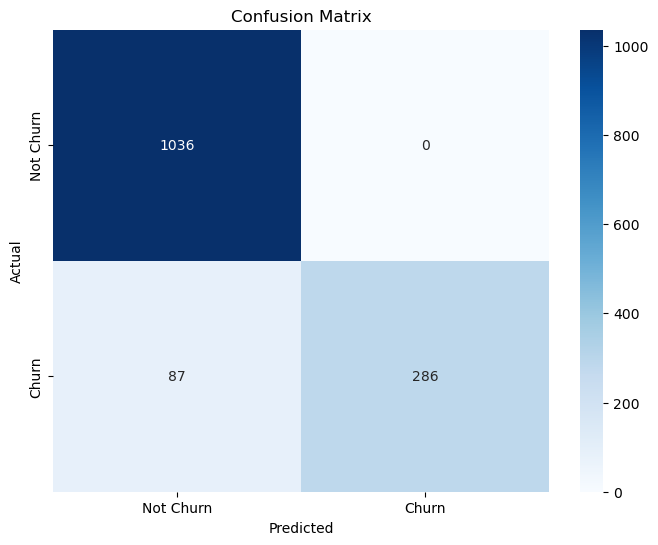

In [18]:
# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Print accuracy score
print('Accuracy score: ', accuracy_score(y_test, y_pred))

Accuracy score:  0.9382540809084458


### Classification Report

- Precision: When our model predicts a customer will churn (1) or not churn (0), it's correct 100% and 92% of the time, respectively. This indicates our model is quite reliable when it predicts churn.
  
- Recall: For the actual churn cases, our model is able to correctly identify 77% of them. However, for the non-churn cases, our model identifies them perfectly (100%). This suggests that our model might be better at identifying non-churn cases than churn cases.

- F1-score: The F1-score is the harmonic mean of precision and recall. The closer to 1, the better. Our model has an F1-score of 0.87 for churn cases (1) and 0.96 for non-churn cases (0). This reinforces the idea that our model is slightly better at predicting non-churn cases.

- Accuracy: The accuracy of our model is 94%, which suggests that it correctly predicted the churn status of customers 94% of the time. This is a good sign of our model's overall effectiveness.

### Confusion Matrix

The confusion matrix gives us a more granular view of the model's performance:

- True negatives (top-left square): The model correctly predicted that 1036 customers would not churn.
- False negatives (bottom-left square): The model incorrectly predicted that 87 customers would not churn, but they actually did.
- True positives (bottom-right square): The model correctly predicted that 286 customers would churn.
- False positives (top-right square): The model predicted that no customers would churn when they actually did not, hence no false positives.

Our model seems to have some difficulty in detecting customers who are going to churn, as indicated by the number of false negatives.

### Accuracy Score

Finally, the overall accuracy of our model is about 93.8%. This score is consistent with the accuracy metric from the classification report and confirms that our model performs well.

However, despite its good overall accuracy, we might want to try to improve its performance on predicting churn customers, which currently stands at 77% (recall for churn). This could involve including more features in our model, tweaking the model's parameters, or trying different algorithms. 

# Data Preprocessing

## Categorical to Numerical Conversion

In [20]:
# Convert No/Yes to 0/1
churn_all['Under 30'] = churn_all['Under 30'].map(dict(Yes=1, No=0))
churn_all['Senior Citizen'] = churn_all['Senior Citizen'].map(dict(Yes=1, No=0))
churn_all['Married'] = churn_all['Married'].map(dict(Yes=1, No=0))
churn_all['Dependents'] = churn_all['Dependents'].map(dict(Yes=1, No=0))
churn_all['Referred a Friend'] = churn_all['Referred a Friend'].map(dict(Yes=1, No=0))
churn_all['Multiple Lines'] = churn_all['Multiple Lines'].map(dict(Yes=1, No=0))
churn_all['Internet Service'] = churn_all['Internet Service'].map(dict(Yes=1, No=0))
churn_all['Online Security'] = churn_all['Online Security'].map(dict(Yes=1, No=0))
churn_all['Online Backup'] = churn_all['Online Backup'].map(dict(Yes=1, No=0))
churn_all['Device Protection Plan'] = churn_all['Device Protection Plan'].map(dict(Yes=1, No=0))
churn_all['Premium Tech Support'] = churn_all['Premium Tech Support'].map(dict(Yes=1, No=0))
churn_all['Streaming TV'] = churn_all['Streaming TV'].map(dict(Yes=1, No=0))
churn_all['Streaming Movies'] = churn_all['Streaming Movies'].map(dict(Yes=1, No=0))
churn_all['Streaming Music'] = churn_all['Streaming Music'].map(dict(Yes=1, No=0))
churn_all['Unlimited Data'] = churn_all['Unlimited Data'].map(dict(Yes=1, No=0))
churn_all['Paperless Billing'] = churn_all['Paperless Billing'].map(dict(Yes=1, No=0))
churn_all['Churn Label'] = churn_all['Churn Label'].map(dict(Yes=1, No=0))

# Convert Gender to a Binary
churn_all['Gender'] = churn_all['Gender'].map(dict(Female=1, Male=0))

In [21]:
# One Hot Encode categoricals (They are not numerically sound)
churn_all = pd.get_dummies(churn_all, columns=['Offer','Phone Service', 'Internet Type', 'Contract', 'Payment Method', 'Customer Status', 'Churn Category', 'Churn Reason'])

Checking if all objects are converted to numericals

In [22]:
if churn_all.select_dtypes(include=['object']).shape[1] == 0:
    print("All object columns successfully converted to numerics!")
else:
    print("Some object columns are still not converted.")

All object columns successfully converted to numerics!


In [23]:
# Drop columns that are derivatives or identical to target variable (churn value)
churn_all = churn_all.drop(['Churn Label', 'Customer Status_Churned', 'Churn Reason_Customer Retained', 'Churn Category_Retention'], axis=1)

In [24]:
churn_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 81 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Gender                                                  7043 non-null   int64  
 1   Age                                                     7043 non-null   int64  
 2   Under 30                                                7043 non-null   int64  
 3   Senior Citizen                                          7043 non-null   int64  
 4   Married                                                 7043 non-null   int64  
 5   Dependents                                              7043 non-null   int64  
 6   Number of Dependents                                    7043 non-null   int64  
 7   Zip Code                                                7043 non-null   int64  
 8   Latitude                              

## Visualization of Converted Features

### Cluster Map

Cluster Map to visualize the objects now converted to numerics and their correlation with other columns

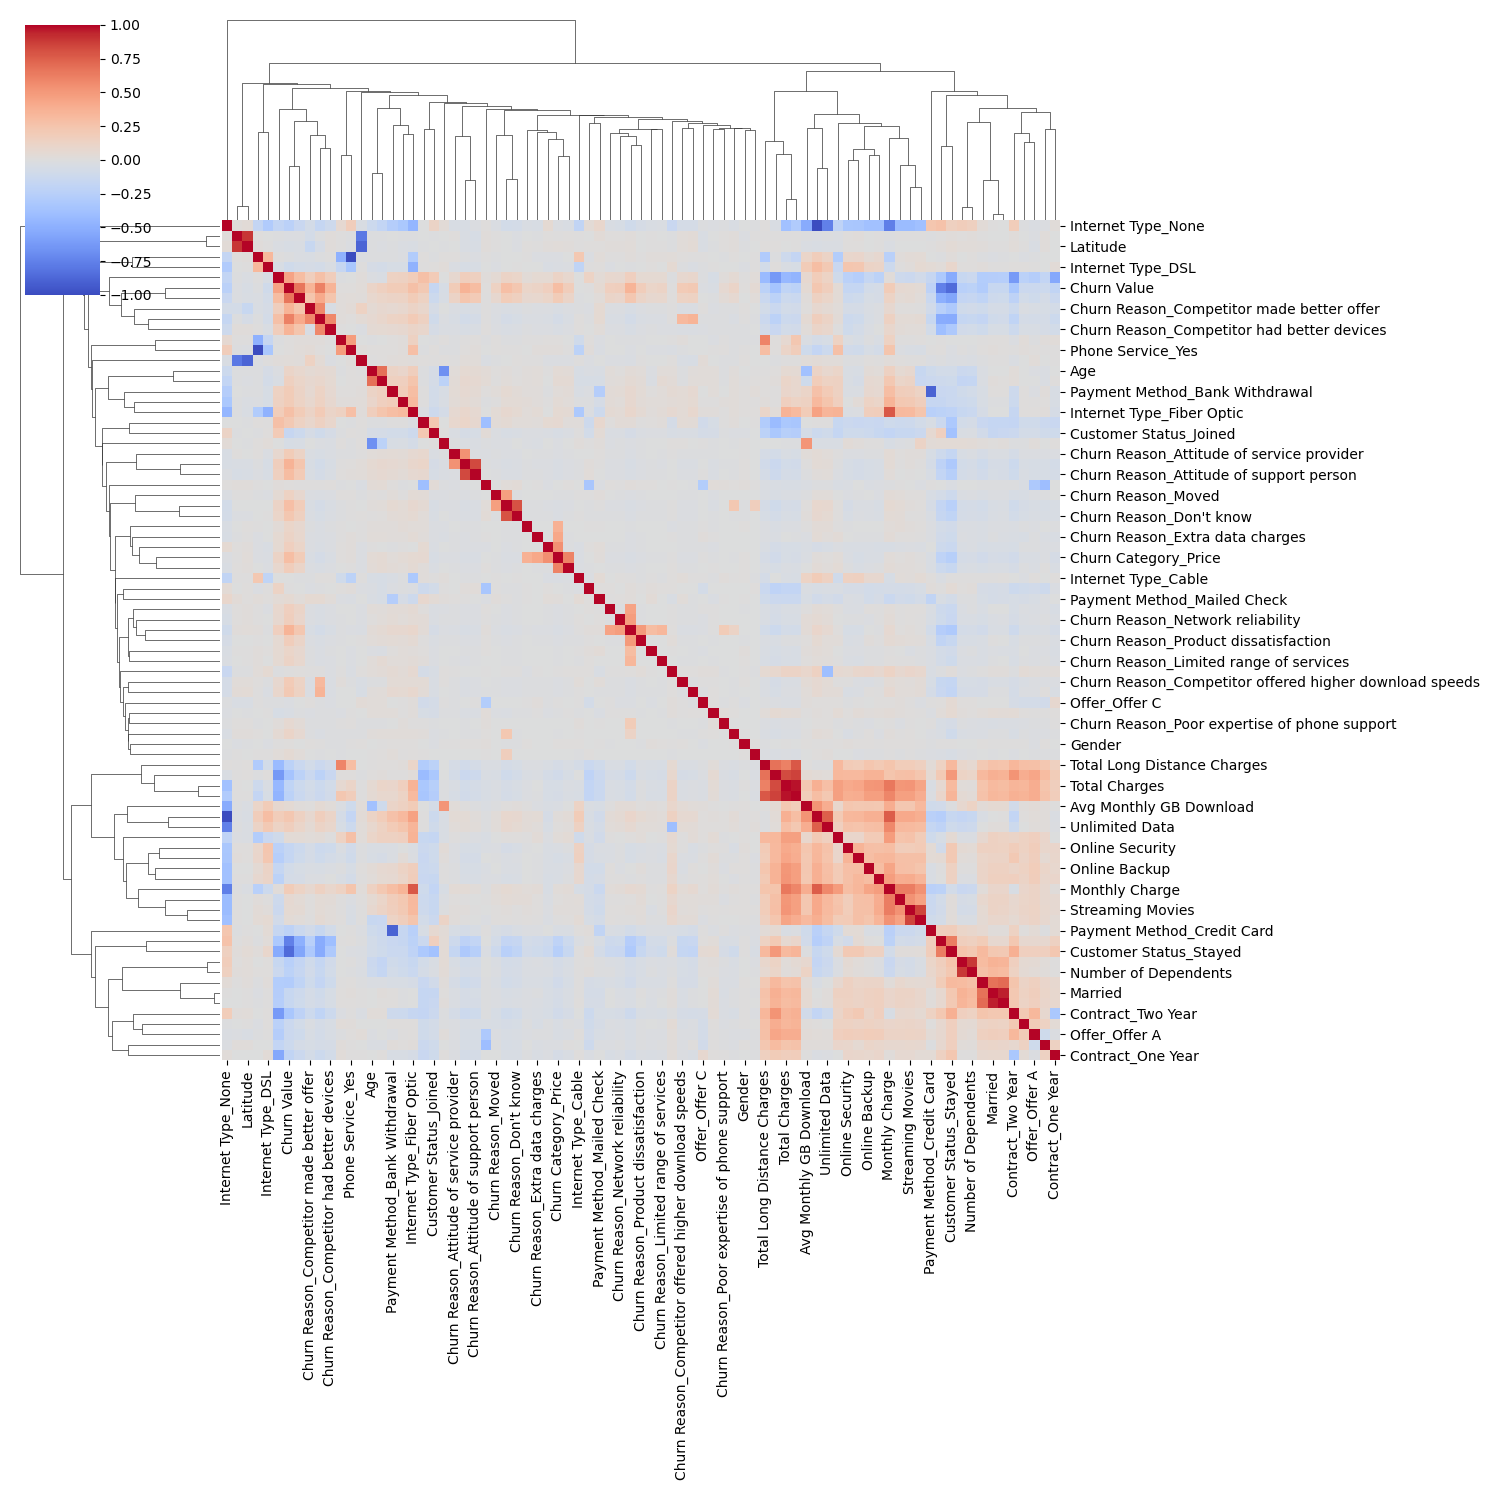

In [25]:
sns.clustermap(churn_all.corr(), annot=False, cmap='coolwarm', figsize=(15,15))

The cluster map visually represents correlation values amongst the various columns in the dataset. On observing this representation, we notice a few interesting aspects:

1. **Lack of Individual Strong Indicators:** It's noteworthy that none of the other features form a close cluster with the churn-related features. This observation suggests that no single feature is a strong determinant of churn. It likely reflects the multifaceted nature of customer behavior, where a combination of various features might influence a customer's decision to churn or not.

2. **Hierarchical Clustering (Dendrogram):** The tree-like structure seen at the top and left of the cluster map is known as a dendrogram. This structure shows a hierarchical clustering of features based on their correlation. The features with higher correlation are grouped together.

3. **Churn Related Features:** The features 'Churn Reason_Competitor made better offer' and 'Churn Reason_Competitor had better devices' are much closer related to churn value than the other churn reasons.

This exploration provides valuable insights about the correlation and potential relationships amongst different features. However, the predictive importance of these features will be better understood when we fit and evaluate a machine learning model. This process will provide a more quantitative measure of feature importance in the context of predicting customer churn.


### t-SNE Visualization

In [26]:
X = churn_all.drop(['Churn Value'], axis=1) 
y = churn_all['Churn Value']

In [27]:
# Fit and transform X to visualizable lower dimensions
transformed = TSNE(n_components=2, random_state=0, perplexity=200, learning_rate=700).fit_transform(X)

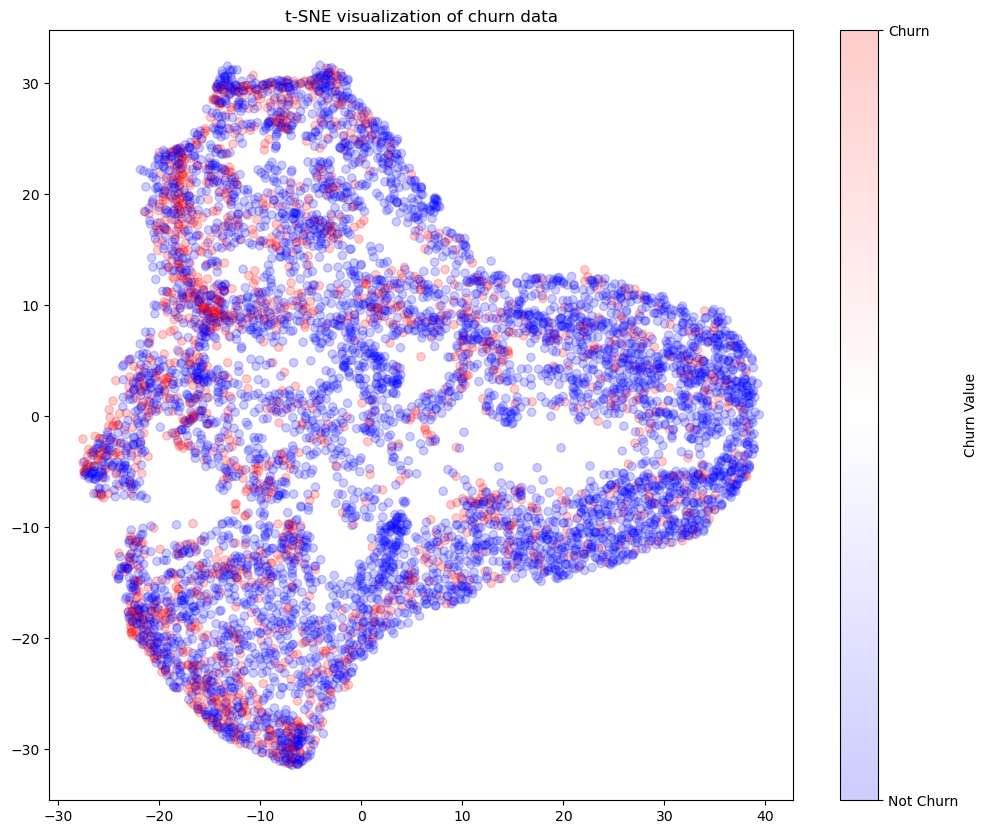

In [28]:
# Plot
plt.figure(figsize=(12,10))

scatter = plt.scatter(transformed[:,0], transformed[:,1], c=y, alpha=0.2, cmap='bwr') # 'bwr' is blue-white-red palette
plt.title('t-SNE visualization of churn data')

# Create a colorbar
cbar = plt.colorbar(scatter, ticks=[0,1])
cbar.set_label('Churn Value')
cbar.set_ticklabels(['Not Churn', 'Churn']) # 0 is "Not Churn", 1 is "Churn"

plt.show()

The t-SNE visualization above illustrates a high-dimensional churn dataset projected into a two-dimensional space. This graphical representation allows us to examine the relationship and potential clusters among customers based on their churn status. Our dataset contains 7043 records, out of which 5174 customers have not churned ('Not Churn').

While there are discernible patterns in the data, it is important to note that the visualization does not exhibit a clear and distinct separation between the 'Churn' and 'Not Churn' classes. 'Not Churn' instances are widely scattered throughout the plot, signifying a diverse set of attributes among customers who did not churn.

In comparison, the 'Churn' points seem to display a slightly more coherent structure, as most of these points tend to be concentrated below the 0 point on the x-axis. This could potentially suggest that the attributes of churned customers share some similarities, thus exhibiting a denser clustering in that specific region.

Despite this, it is evident that the 'Churn' instances are not exclusively confined to that area and are still dispersed across the plot. This highlights the complex and multi-faceted nature of customer churn, hinting at the presence of multiple factors that could lead to a customer's decision to leave the service.

This data visualization underscores the potential feasibility of predicting customer churn using machine learning algorithms. Nonetheless, the overlap between 'Churn' and 'Not Churn' instances suggests that achieving high predictive accuracy may be challenging due to the inherent intricacies in customer behavior. Hence, it is essential to further explore the data and refine our prediction model for improved outcomes.

# Refined Model Development

In this section, we'll start to consider the full complexity of our data and start to develop more sophisticated models. We'll experiment with different model types, including more complex models like decision trees, random forests, and gradient boosting machines.

## Feature Engineering and Selection

In this section, we'll perform several steps to prepare and optimize the features we're using to make predictions.

- **Potential Predictive Features Identification:** Initially, we identify a set of potential features that could feasibly affect the target variable. This pool of features will serve as our starting point for feature engineering and selection.

- **Feature Importance Analysis:** Next, we'll analyze these potential predictive features to understand which ones are most important for making predictions.

- **Feature Selection:** Based on our analysis of feature importance, we'll decide which of these potential features to actually use for training our model.

- **Dimensionality Reduction:** Lastly, we'll use methods like Principal Component Analysis (PCA) to reduce the number of features in our dataset, if necessary.


### Potential Predictive Features Identification

When designing a predictive model, it's essential to select the most relevant features that influence the target variable. In this case, we're predicting customer churn, so we've chosen a range of features that could feasibly affect a customer's decision to leave the company. 

The chosen `predictive_features` are a mix of demographic information about the customer (like `Age`, `Gender`, `Married`, `Dependents` etc.), their geographic information (`Zip Code`, `Latitude`, `Longitude`), their interaction with the company (`Referred a Friend`, `Number of Referrals`, `Tenure in Months` etc.), the services they've subscribed to (`Internet Service`, `Online Security`, `Device Protection Plan`, `Streaming TV` etc.), their billing and charge details (`Avg Monthly Long Distance Charges`, `Total Charges`, `Total Refunds`, `Monthly Charge` etc.), their satisfaction and value metrics (`Satisfaction Score`, `CLTV`), and several one-hot encoded features about their chosen offer, phone and internet service, contract duration, and payment method.

We've intentionally avoided including features like `Churn Reason` or `Churn Category` in our predictive feature set. The primary reason is that this information would only be available after a customer has already churned, so it's not useful for prediction. If we were to include these features, our model would likely achieve very high accuracy, but this would be due to data leakage, where our model has access to information that wouldn't be available in a real-world prediction scenario. 

For example, if we included `Churn Reason` as a predictive feature and a given customer has a specific churn reason associated with them, our model could infer that this customer has already churned, achieving a 'perfect' prediction. However, this wouldn't be because our model has learned any meaningful patterns in the data; it would merely be exploiting the fact that it has been given information that it shouldn't have.

Therefore, to build a predictive model that's useful in the real world, we've chosen features that would be available to us before a customer decides to churn.


In [29]:
predictive_features = ['Gender', 'Age', 'Under 30', 'Senior Citizen', 'Married', 'Dependents', 
                      'Number of Dependents', 'Zip Code', 'Latitude', 'Longitude', 
                      'Referred a Friend', 'Number of Referrals', 'Tenure in Months', 
                      'Avg Monthly Long Distance Charges', 'Multiple Lines', 
                      'Internet Service', 'Avg Monthly GB Download', 'Online Security', 
                      'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 
                      'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 
                      'Paperless Billing', 'Monthly Charge', 'Total Charges', 'Total Refunds', 
                      'Total Extra Data Charges', 'Total Long Distance Charges', 
                      'Total Revenue', 'Satisfaction Score', 'CLTV', 
                      'Offer_Offer A', 'Offer_Offer B', 'Offer_Offer C', 'Offer_Offer D', 
                      'Offer_Offer E', 'Phone Service_Yes', 'Internet Type_DSL', 
                      'Internet Type_Fiber Optic', 'Internet Type_None', 'Contract_One Year', 
                      'Contract_Two Year', 'Payment Method_Credit Card', 
                      'Payment Method_Mailed Check']

In [30]:
X = churn_all[predictive_features]
y = churn_all['Churn Value']

In [31]:
# Divide data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [32]:
# Select only numeric columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train[numeric_cols])

# Apply transform to both the training set and the test set.
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Fit the model 
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train[numeric_cols], y_train)

LogisticRegression(max_iter=500)

### Feature Importance Analysis

We'll try to understand which features are most important for making predictions.

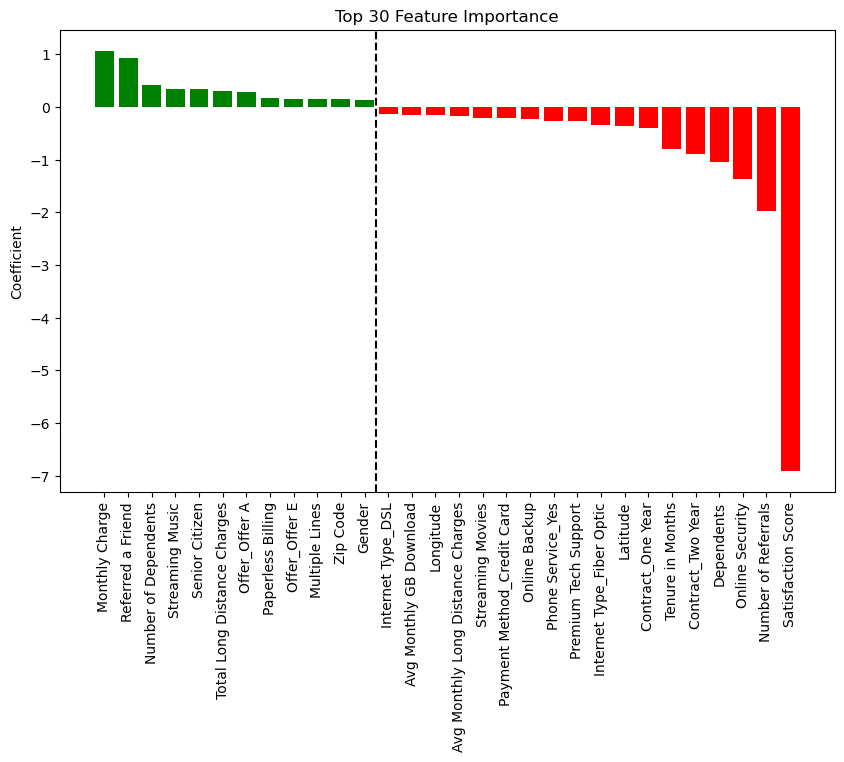

In [33]:
# Get importance
importance = logreg.coef_[0]

# Create a dataframe of features and their importance
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})

# Take absolute value of coefficients for ranking
feature_importance['abs_importance'] = feature_importance['Importance'].abs()

# Sort by absolute importance
feature_importance = feature_importance.sort_values('abs_importance', ascending=False)

# Select top 30 features
top_features = feature_importance.iloc[:30]

# Sort the top_features DataFrame in descending order by Importance for the plot
top_features = top_features.sort_values('Importance', ascending=False)

# Color based on positive or negative coefficient
colors = ['green' if x > 0 else 'red' for x in top_features['Importance']]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(top_features['Feature'], top_features['Importance'], color=colors)
plt.xticks(rotation='vertical')
plt.title("Top 30 Feature Importance")
plt.ylabel("Coefficient")

# Find the position of the first negative coefficient
first_negative = np.where(top_features['Importance']<0)[0]
if len(first_negative) > 0:
    plt.axvline(x=first_negative[0]-0.5, color='black', linestyle='--')  # Draw a vertical line

plt.show()

In the chart above, we're visualizing the top 30 features that influence the prediction of customer churn, according to our logistic regression model. The y-axis represents the coefficient value of each feature from the logistic regression model.

A positive coefficient (green bar) suggests that as the feature value increases, the probability of churn also increases. In other words, these features have a positive relationship with the chance of customer churn.

For instance, if **Monthly Charge** has a coefficient of 1, it means that for a unit increase in **Monthly Charge**, the log-odds of the customer churning (i.e., 'Churn = 1') increases by 1 unit, keeping all other features constant. Log-odds can be interpreted as the logarithm of the odds of the event happening. In our case, it's the log of the odds of a customer churning. 

Negative coefficients (red bars), on the other hand, mean that as the feature value increases, the probability of churn decreases. In other words, these features have a negative relationship with the chance of customer churn.

For instance, if **Number of Referrals** has a coefficient of -2, it means that for a unit increase in **Number of Referrals**, the log-odds of the **customer churning** decreases by 2 units, keeping all other features constant.

The magnitude (size) of these coefficients also matters. Larger absolute values mean the feature has a stronger impact on the outcome. A feature with a coefficient of -2 will have a stronger impact on the model's prediction than a feature with a coefficient of -1.

Bear in mind, however, that these interpretations assume that the relationship between each feature and the outcome is linear and that all other features are held constant. This may not be true in all situations, especially when dealing with complex, real-world data. Therefore, while these interpretations can be helpful in understanding the model's behavior, they should be taken with a grain of caution.


### Feature Selection

Based on our analysis of feature importance, we'll decide which features to use for training our model.

The main goal of this section is to choose features that are most relevant to predicting `churn value`, improving model performance by reducing complexity and overfitting, and improving interpretability.

In [34]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# sorting the data
vif_data = vif_data.sort_values('VIF')  # sort ascending (default)

print(vif_data)

C:\Users\sergi\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                              feature           VIF
0                              Gender  1.004987e+00
36                      Offer_Offer C  1.064712e+00
46        Payment Method_Mailed Check  1.113657e+00
37                      Offer_Offer D  1.129528e+00
25                  Paperless Billing  1.208343e+00
33                               CLTV  1.208638e+00
45         Payment Method_Credit Card  1.211649e+00
35                      Offer_Offer B  1.241748e+00
32                 Satisfaction Score  1.303919e+00
38                      Offer_Offer E  1.334617e+00
34                      Offer_Offer A  1.398675e+00
43                  Contract_One Year  1.622399e+00
11                Number of Referrals  2.136261e+00
17                    Online Security  2.250742e+00
20               Premium Tech Support  2.306634e+00
18                      Online Backup  2.379737e+00
40                  Internet Type_DSL  2.405935e+00
44                  Contract_Two Year  2.423559e+00
19          

**VIF Analysis and Interpretation**

We computed the Variance Inflation Factor (VIF) for each feature to measure the extent of correlation among them. High VIF values, generally above 5 or 10, signify high multicollinearity which can impact model performance.

Key findings:
- Features like 'Married', 'Referred a Friend', 'Internet Service' and several 'Total' features exhibited high VIF values, suggesting high correlation with other features.
- 'Total' features displayed VIF values as 'inf', hinting at perfect multicollinearity, likely due to these features being derived from other variables.
- 'Internet Service' and 'Internet Type_Fiber Optic' had particularly high VIF values, indicating potential correlation with other internet related features.

Based on these findings, we may consider removing features with high VIF values to improve model interpretability and performance. The visual in the next section will guide our decision-making process.

In [35]:
# Select and sort features
sorted_vif = vif_data.sort_values('VIF', ascending=True)
# Create a copy of the sorted_vif dataframe which is all VIF values under 10 
final_vif = sorted_vif[sorted_vif['VIF'] <= 10].copy()

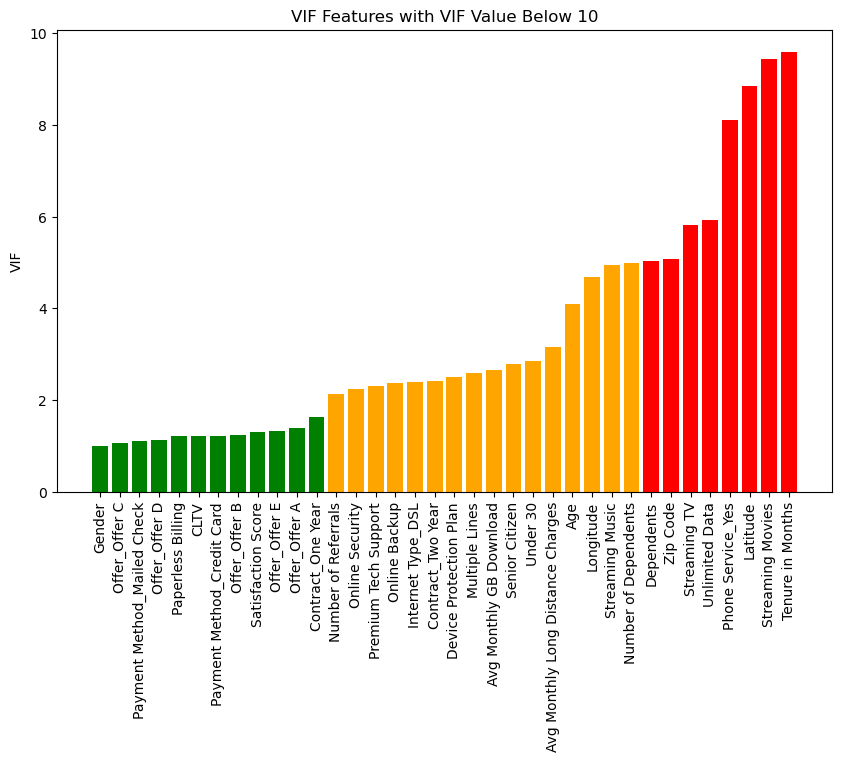

In [36]:
# Create a new column for colors
final_vif['color'] = ['green' if vif <= 2 else 'orange' if vif <= 5 else 'red' for vif in final_vif['VIF']]

# Plot feature VIF
plt.figure(figsize=(10, 6))
plt.bar(final_vif['feature'], final_vif['VIF'], color=final_vif['color'])
plt.xticks(rotation='vertical')
plt.title("VIF Features with VIF Value Below 10")
plt.ylabel("VIF")

plt.show()

**Visual Interpretation of VIF Values**

The bar chart above visualizes the VIF values of the selected features, color-coded for ease of interpretation:
- **Green**: VIF <= 2, these features exhibit low multicollinearity and are solid candidates for inclusion in our model.
- **Orange**: 2 < VIF <= 5, these features have moderate multicollinearity but can still be reasonably included in our model.
- **Red**: 5 < VIF <= 10, these features show high multicollinearity. Their inclusion in the model could be considered, however, they could also be excluded if constraints such as model complexity or overfitting become an issue.

The VIF analysis has helped us to identify the most important and least correlated features, guiding us in feature selection for our predictive model. Our aim is to include the green and orange features definitely, and the red ones conditionally, based on the specific requirements and constraints of the model.


In [37]:
# List of feature names with VIF <= 10
selected_feature_names = final_vif['feature'].tolist()

# Additional features to exclude based on further rationale
features_to_exclude = ['Age', 'Longitude', 'Zip Code', 'Latitude']

# Filter out the additional features from the selected_feature_names
selected_feature_names = [feature for feature in selected_feature_names if feature not in features_to_exclude]

# Create new DataFrame with selected features
selected_features_df = churn_all[selected_feature_names]

In [38]:
selected_features_df.describe()

,Gender,Offer_Offer C,Payment Method_Mailed Check,Offer_Offer D,Paperless Billing,CLTV,Payment Method_Credit Card,Offer_Offer B,Satisfaction Score,Offer_Offer E,...,Under 30,Avg Monthly Long Distance Charges,Streaming Music,Number of Dependents,Dependents,Streaming TV,Unlimited Data,Phone Service_Yes,Streaming Movies,Tenure in Months
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.495244,0.058924,0.054664,0.085475,0.592219,4400.295755,0.390317,0.116996,3.244924,0.114298,...,0.198921,22.958954,0.353259,0.468692,0.231010,0.384353,0.673719,0.903166,0.387903,32.386767
std,0.500013,0.235499,0.227340,0.279607,0.491457,1183.057152,0.487856,0.321438,1.201657,0.318195,...,0.399217,15.448113,0.478016,0.962802,0.421508,0.486477,0.468885,0.295752,0.487307,24.542061
min,0.000000,0.000000,0.000000,0.000000,0.000000,2003.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,3469.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,9.210000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,4527.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,22.890000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000
75%,1.000000,0.000000,0.000000,0.000000,1.000000,5380.500000,1.000000,0.000000,4.000000,0.000000,...,0.000000,36.395000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,55.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,6500.000000,1.000000,1.000000,5.000000,1.000000,...,1.000000,49.990000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,72.000000


**Rationale for Further Feature Selection**

Besides the initial feature selection based on Variance Inflation Factor (VIF), we performed additional filtering to remove certain features based on other considerations. 

1. **`Age`**: The `Age` feature was removed from our final selection despite its moderate VIF score (~4). The reasoning behind this is twofold. First, our previous feature importance analysis did not rank `Age` among the top 30 features, indicating its relatively lower significance. Second, we have included the `Under 30` feature in our model, which likely captures the key information from `Age`, thereby allowing for a more generalized model while reducing multicollinearity.

2. **`Longitude`, `Zip Code`, and `Latitude`**: These features, although offering valuable geographical insights, were excluded to prevent overfitting in the predictive model. While these attributes might be beneficial in identifying trends or local anomalies (such as a poorly performing local branch), they might contribute to model overfitting in a predictive context. Once the local anomalies are resolved, a model trained on these features might lose accuracy due to overfitting. By removing these features, we aim to enhance the model's generality and robustness.

By refining our feature selection in this manner, we aim to balance the trade-off between model complexity, overfitting, and interpretability, while ensuring a reliable predictive performance.

### Dimensionality Reduction

Dimensionality reduction techniques like Principal Component Analysis (PCA) are often useful for reducing the complexity of our data and mitigating issues like overfitting or long computation times. They work by transforming the original features into a smaller set of new components that capture most of the information in the data.

However, PCA comes with a cost: the new components are less interpretable than the original features because they are combinations of those original features. In other words, PCA may make our models less understandable and harder to explain.

In [39]:
scaler = StandardScaler()  #PCA is affected by scale
scaled_data = scaler.fit_transform(selected_features_df)

In [40]:
pca = PCA(n_components=30) 
pca_data = pca.fit_transform(scaled_data)

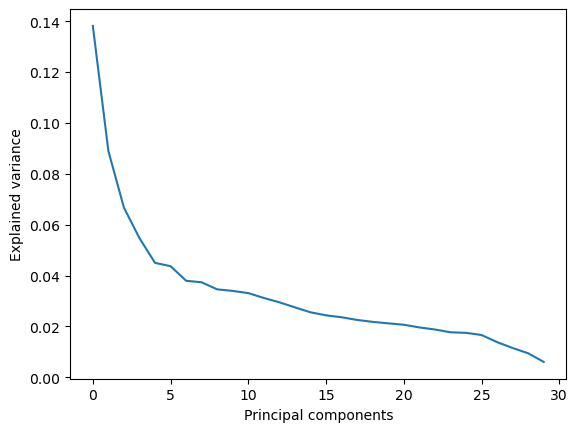

In [41]:
explained_variance = pca.explained_variance_ratio_
plt.plot(range(len(explained_variance)), explained_variance)
plt.ylabel('Explained variance')
plt.xlabel('Principal components')
plt.show()

In [42]:
# Apply PCA.
pca = PCA(n_components = len(selected_features_df.columns))
pca_data = pca.fit_transform(scaled_data)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Print explained variance ratio for each component
for i, explained_var in enumerate(explained_variance_ratio):
    print(f'Principal Component {i+1}: {explained_var*100:.2f}% of the variance')

# Print cumulative explained variance
print('\nCumulative explained variance:')
for i, cumul_var in enumerate(cumulative_explained_variance):
    print(f'First {i+1} components: {cumul_var*100:.2f}% of the variance')

Principal Component 1: 13.81% of the variance
Principal Component 2: 8.90% of the variance
Principal Component 3: 6.67% of the variance
Principal Component 4: 5.47% of the variance
Principal Component 5: 4.50% of the variance
Principal Component 6: 4.37% of the variance
Principal Component 7: 3.80% of the variance
Principal Component 8: 3.74% of the variance
Principal Component 9: 3.46% of the variance
Principal Component 10: 3.40% of the variance
Principal Component 11: 3.31% of the variance
Principal Component 12: 3.12% of the variance
Principal Component 13: 2.95% of the variance
Principal Component 14: 2.75% of the variance
Principal Component 15: 2.56% of the variance
Principal Component 16: 2.44% of the variance
Principal Component 17: 2.36% of the variance
Principal Component 18: 2.26% of the variance
Principal Component 19: 2.18% of the variance
Principal Component 20: 2.12% of the variance
Principal Component 21: 2.07% of the variance
Principal Component 22: 1.96% of the varia

After performing an exploratory PCA, we found that to retain 90% of the variance in the data, we would need 23 new principal components. Considering that we initially have 32 features, this reduction is not substantial enough to justify the loss in interpretability. Therefore, we decided not to apply PCA for this analysis and will proceed with the features selected from our previous steps.

This decision allows us to maintain a higher degree of interpretability in our models, which is important for understanding and communicating our results.

## Handling Class Imbalance

In this section, we'll address any class imbalance in our target variable.

(To be decided)We'll use strategies such as oversampling the minority class, undersampling the majority class, or using techniques like SMOTE.

Churn value counts:
0    5174
1    1869
Name: Churn Value, dtype: int64


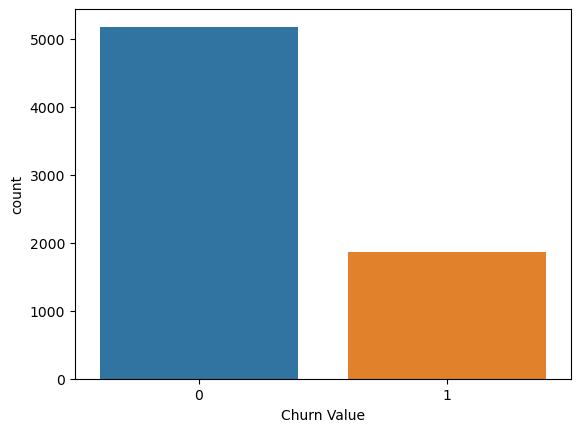

In [43]:
# Bar plot of the target variable
sns.countplot(x='Churn Value', data=churn_all)

# Count the values of each class in the target variable
churn_counts = y.value_counts()

print("Churn value counts:")
print(churn_counts)

***EDIT THIS SHIT:*** ***

SMOTE (Synthetic Minority Over-sampling Technique): SMOTE is a more sophisticated method that generates synthetic examples from the minority class instead of simply duplicating existing examples. It does this by selecting two or more similar instances (using a distance measure) and perturbing an instance one attribute at a time by a random amount within the difference to the neighboring instances. This method can provide better performance and generalization, as the new instances it creates are "new" and not just copies of existing instances. But SMOTE can lead to high false-positive rates if the minority class is particularly noisy.

Choosing between oversampling and SMOTE depends on the specifics of your data and the problem you are trying to solve. Here are some things to consider:

If your minority class data is not particularly noisy and the instances of the minority class are close to each other (i.e., they are not spread out over the space spanned by the instances of the majority class), SMOTE can be a good option.

If the minority class instances are scattered widely, SMOTE might not be the best choice, as it could generate noise by interpolating new points between distant minority instances. In this case, you might want to try simpler oversampling or perhaps undersampling the majority class.

Finally, you should test both techniques and see which one works better for your particular problem. You can use cross-validation or a separate validation set to compare the performance of models trained with oversampled and SMOTE-augmented data.


In [44]:
X = selected_features_df
y = churn_all['Churn Value']

In [45]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [46]:
# Define the scaler 
scaler = StandardScaler()

# Fit on the training data
scaler.fit(X_train)

# Transform both the training and testing data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
# Create a SMOTE instance
smote = SMOTE(random_state=0)

# Apply SMOTE to training data only
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check the balance of the target variable in the augmented dataset
print(y_train_res.value_counts())

0    4138
1    4138
Name: Churn Value, dtype: int64


In [48]:
X_train_res

array([[-0.97579862, -0.24983494, -0.23506125, ...,  0.3262537 ,
         1.25356634,  0.75100602],
       [-0.97579862, -0.24983494, -0.23506125, ...,  0.3262537 ,
        -0.79772404, -0.43009948],
       [ 1.02480161, -0.24983494, -0.23506125, ...,  0.3262537 ,
         1.25356634,  1.40265044],
       ...,
       [-0.97579862, -0.24983494, -0.23506125, ...,  0.3262537 ,
        -0.79772404, -1.27670944],
       [ 0.63557182, -0.24983494, -0.23506125, ..., -3.06509934,
         0.85447445, -1.18918803],
       [ 1.02480161, -0.24983494, -0.23506125, ...,  0.3262537 ,
        -0.79772404, -0.85366631]])

<Axes: xlabel='Churn Value', ylabel='count'>

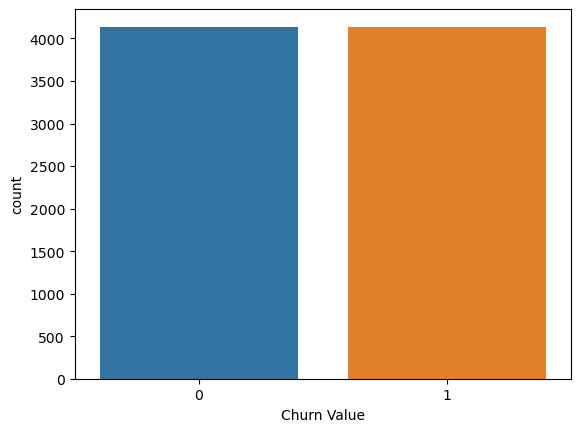

In [50]:
# Convert y_resampled to a DataFrame for easier plotting
y_resampled_df = pd.DataFrame(y_train_res, columns=['Churn Value'])

# Bar plot of the target variable in the resampled data
sns.countplot(x='Churn Value', data=y_resampled_df)

## Model Comparisons

### Logistic Regression Model

In [51]:
# Now let's perform logistic regression on the resampled training data
logistic_reg = LogisticRegression(max_iter=1000)  # Increased max_iter to ensure convergence
logistic_reg.fit(X_train_res, y_train_res)

# Now we predict on the test data
y_pred_res = logistic_reg.predict(X_test)

# Let's print classification report, confusion matrix, and accuracy score for this model
print("Classification Report:")
print(classification_report(y_test, y_pred_res))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_res))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_res))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1036
           1       0.89      0.91      0.90       373

    accuracy                           0.95      1409
   macro avg       0.93      0.94      0.93      1409
weighted avg       0.95      0.95      0.95      1409

Confusion Matrix:
[[996  40]
 [ 34 339]]
Accuracy Score:
0.9474804826117814


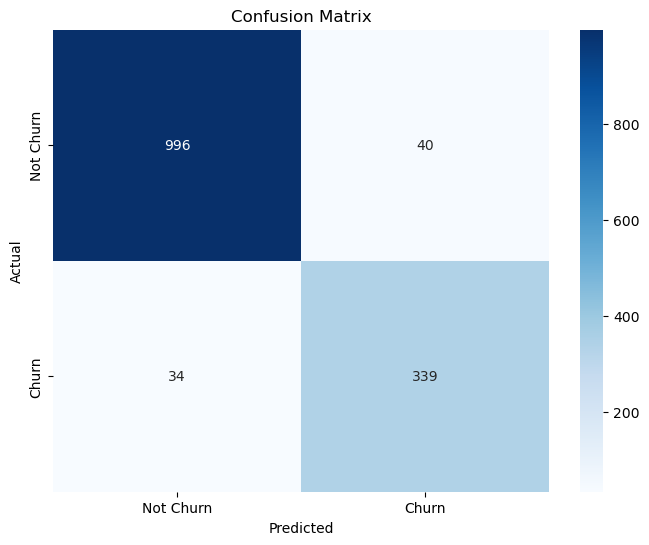

In [52]:
# Get confusion matrix
cm = confusion_matrix(y_test, y_pred_res)

# Plot confusion matrix with seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Analysis of Logistic Regression Model

**Precision:** For our updated model, when it predicts a customer will churn (1), it is correct 89% of the time, and when it predicts a customer will not churn (0), it's correct 97% of the time. While there's a slight decrease in precision for the churn prediction, it's a trade-off we make for significantly improved recall.

**Recall:** Our model has improved significantly in terms of recall for churn cases (1), correctly identifying 91% of actual churn cases, a noticeable increase from the preliminary model's 77%. However, there's a small decrease for non-churn cases to 96%. The improvement in recall for churn cases demonstrates the effectiveness of addressing class imbalance.

**F1-score:** The F1-scores for churn and non-churn cases are 0.90 and 0.96 respectively. While there's a slight dip in F1-score for non-churn cases, the increase in F1-score for churn cases (from 0.87 to 0.90) is a positive indication that the model's balance between precision and recall for churn predictions has improved.

**Accuracy:** The overall accuracy of our model is approximately 94.7%. While this is similar to the preliminary model's accuracy, the re-balancing of precision and recall is an important step towards creating a more robust and reliable model.

**Confusion Matrix**
The confusion matrix for our updated model gives us a clearer view of its performance:

True negatives (top-left square): The model correctly predicted that 996 customers would not churn.
False positives (top-right square): The model incorrectly predicted that 40 customers would churn, but they actually did not.
False negatives (bottom-left square): The model incorrectly predicted that 34 customers would not churn, but they actually did.
True positives (bottom-right square): The model correctly predicted that 339 customers would churn.
Overall, the model has become better at detecting customers who are going to churn, as indicated by the decrease in false negatives and increase in true positives.

**Accuracy Score**
The accuracy score of our updated model is about 94.7%. The consistency of this score with the accuracy metric from the classification report confirms that our model performs well. However, its more balanced performance across churn and non-churn cases demonstrates the effectiveness of addressing class imbalance through techniques like SMOTE.

### Random Forest Model

In [53]:
# Instantiate the model
random_forest = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit the model
random_forest.fit(X_train_res, y_train_res)

# Predict on the test data
y_pred_rf = random_forest.predict(X_test)

# Let's print classification report, confusion matrix, and accuracy score for this model
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_rf))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1036
           1       0.96      0.88      0.92       373

    accuracy                           0.96      1409
   macro avg       0.96      0.93      0.95      1409
weighted avg       0.96      0.96      0.96      1409

Confusion Matrix:
[[1024   12]
 [  45  328]]
Accuracy Score:
0.9595457771469127


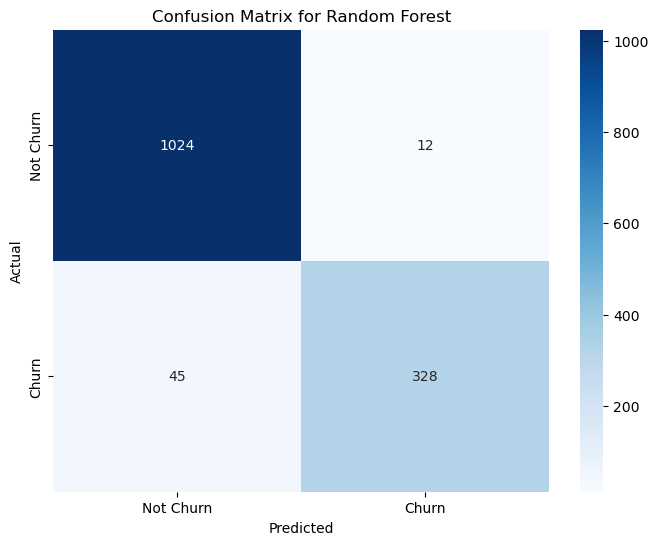

In [55]:
# Get confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix with seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

####  Analysis of Random Forest Model

**Precision:** When our Random Forest model predicts a customer will churn (1) or not churn (0), it's correct 96% of the time for both cases. This shows that our model is very reliable when it comes to making predictions.

**Recall:** For the actual churn cases, our model can correctly identify 88% of them. On the other hand, for the non-churn cases, the model identifies 99% of them correctly. This suggests that our model is quite good at identifying non-churn cases, and fairly good, although not perfect, at identifying churn cases.

**F1-score:** The F1-score for churn cases (1) is 0.92 and for non-churn cases (0) it is 0.97. The F1-score is the harmonic mean of precision and recall, and a higher F1-score is desirable. Our model has done a commendable job at balancing precision and recall for both churn and non-churn cases.

**Confusion Matrix**

The confusion matrix allows us to visualize the performance of our model:

True negatives (top-left square): The model correctly predicted that 1024 customers would not churn.
False negatives (bottom-left square): The model incorrectly predicted that 45 customers would not churn, but they actually did.
True positives (bottom-right square): The model correctly predicted that 328 customers would churn.
False positives (top-right square): The model incorrectly predicted that 12 customers would churn, but they did not.
Our model has shown considerable performance in predicting the churn status of customers, although there are still some cases where the model falsely predicts the churn status.

**Accuracy Score**

The overall accuracy of our Random Forest model is approximately 95.9%. This score is impressive and confirms that our model performs extremely well. This model has a higher accuracy compared to the logistic regression model on the resampled data, which had an accuracy of around 94.7%.

However, similar to the logistic regression model, there is still room for improvement in identifying churn cases as evidenced by the recall score for churn (88%). 

In [61]:
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': random_forest.feature_importances_})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [63]:
# Print sorted feature importances above
print(feature_importances)

                              feature  importance
8                  Satisfaction Score    0.471647
12                Number of Referrals    0.066431
17                  Contract_Two Year    0.062607
31                   Tenure in Months    0.060229
20            Avg Monthly GB Download    0.038767
6          Payment Method_Credit Card    0.028303
4                   Paperless Billing    0.026899
26                         Dependents    0.024841
11                  Contract_One Year    0.023117
25               Number of Dependents    0.022114
13                    Online Security    0.021996
5                                CLTV    0.021558
23  Avg Monthly Long Distance Charges    0.020795
14               Premium Tech Support    0.020073
28                     Unlimited Data    0.011277
16                  Internet Type_DSL    0.008388
15                      Online Backup    0.007977
19                     Multiple Lines    0.007823
21                     Senior Citizen    0.007001


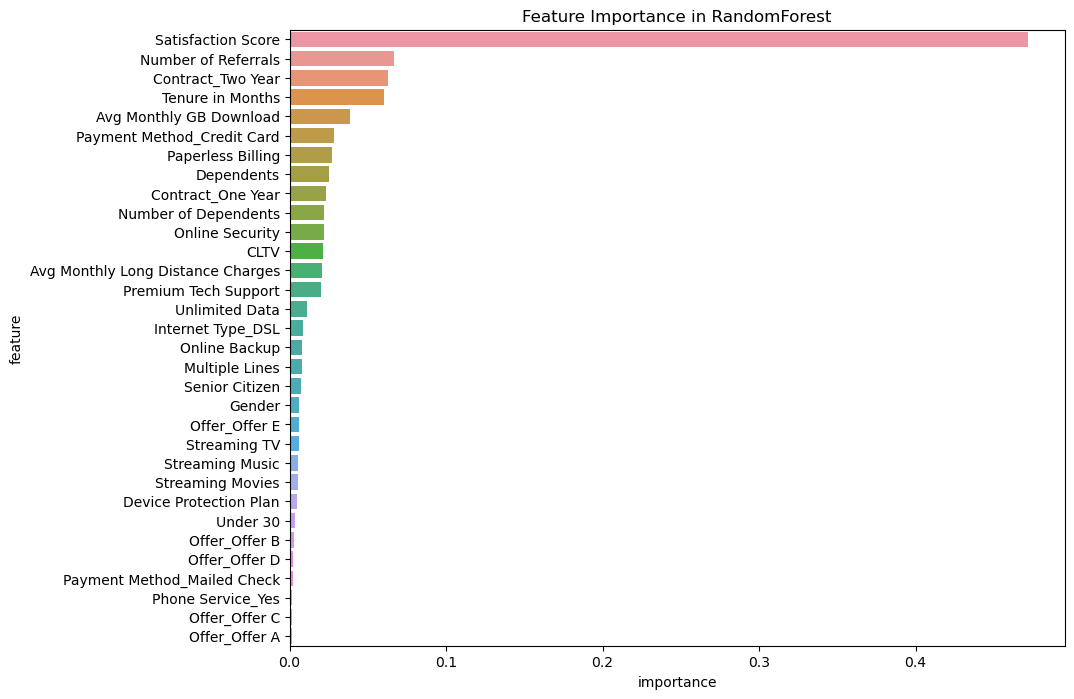

In [62]:
# Plot feature importances
plt.figure(figsize=(10,8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance in RandomForest')
plt.show()

#### Feature Importance in RandomForest Model

The bar plot above visualizes the importance of each feature in our Random Forest model. These importances are computed by looking at how much the tree nodes, which use these features, reduce impurity on average across all trees in the forest. They are then normalized so that the sum of all importances is equal to 1. 

In our model, we find that the feature with the highest importance by a significant margin is `Satisfaction Score` (0.47). This implies that customers' satisfaction score is the most influential factor when predicting whether a customer will churn or not. 

The next most important features, though significantly less influential than `Satisfaction Score`, are `Number of Referrals` (0.066), `Contract_Two Year` (0.063), `Tenure in Months` (0.060), and `Avg Monthly GB Download` (0.039). These suggest that customer loyalty, reflected through long-term contracts and referrals, length of tenure with the company, and the amount of data they download, also play substantial roles in determining customer churn.

We also notice that many other features, such as `Payment Method_Credit Card`, `Paperless Billing`, and `Dependents`, hold some importance in our model. While these do not have as much of an impact individually as the top features, they may still collectively contribute a significant effect on the prediction. 

On the other hand, there are some features that have very little influence in the model. These include `Offer_Offer B`, `Offer_Offer D`, `Payment Method_Mailed Check`, and `Phone Service_Yes` among others. 

In sum, this feature importance analysis helps us understand which aspects are crucial in predicting customer churn and could inform potential business strategies to improve customer retention. We should focus on improving customer satisfaction and look into ways to encourage longer tenure, as these are the most influential factors. 

Please note, feature importance does not imply causality, and a higher importance does not mean a feature has a positive effect on the target variable. Rather, it simply suggests a strong association between the feature and the target variable.

## Model Tuning

In this section, we'll optimize our model's hyperparameters to improve its performance. We'll use techniques like grid search and random search to find the optimal hyperparameters.

### 

# Model Evaluation

Now that we've chosen our final model and tuned its hyperparameters, we'll evaluate its performance. We'll generate predictions on our test set and calculate metrics like accuracy, precision, recall, F1 score, and ROC AUC.

# Conclusion

In this final section, we'll summarize our findings and discuss their implications. 

We'll also suggest future steps for further investigation or improvement.